In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Microtubule")
log_dir = root_dir / "Logs"
events_path = log_dir / "events.h5"

# Explore Existing Models Training Summaries

In [ ]:
previous_events = None
if events_path.is_file():
    previous_events = pd.read_hdf(str(events_path), "events")
    
logs_path = {}
for model_path in log_dir.iterdir():
    if model_path.is_dir() and model_path.name != ".ipynb_checkpoints":
        logs_path[model_path.name] = list(model_path.glob("*.out.tfevents.*"))
        
events = {}

for model_name, log_path in logs_path.items():
    for single_log_path in log_path:
        for summary in tf.train.summary_iterator(str(single_log_path)):
            if summary.HasField("summary"):
                datum = {}
                datum["model_name"] = model_name
                datum["step"] = summary.step
                datum["wall_time"] = summary.wall_time
                datum[summary.summary.value[0].tag] = summary.summary.value[0].simple_value

                key_name = f"{model_name}_{summary.step}"
                if key_name not in events.keys():
                    events[key_name] = {}

                events[key_name].update(datum)
        
events = pd.DataFrame.from_dict(events).T
events = events.sort_values(["model_name", "step"])
events.reset_index(inplace=True, drop=True)

if previous_events is not None:
    events = pd.concat([events, previous_events])
    events.drop_duplicates(["model_name", "step"], inplace=True)
    events = events.sort_values(["model_name", "step"])

events.to_hdf(str(events_path), "events")

In [5]:
#events = pd.read_hdf(str(events_path), "events")

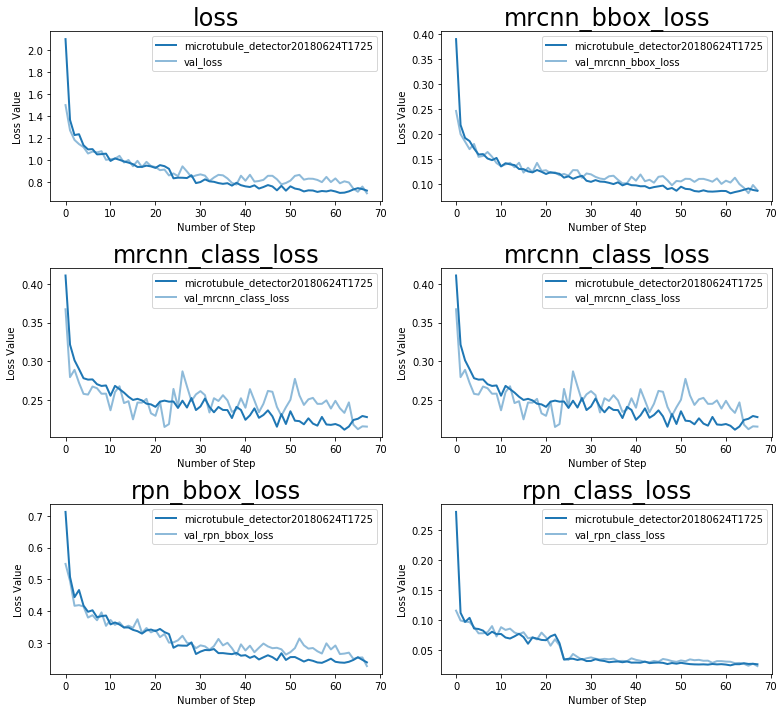

In [12]:
features = ["loss", "mrcnn_bbox_loss", "mrcnn_class_loss", "mrcnn_class_loss",
            "rpn_bbox_loss", "rpn_class_loss"]

nrows = len(features) // 2
nrows += 1 if len(features) % 2 > 0 else 0
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(11, 10))

for ax, feature in zip(axs.flat, features):
    for i, row in events.groupby("model_name"):
        line = ax.plot(row.step, row[f"{feature}"], lw=2, label=i)[0]
        ax.plot(row.step, row[f"val_{feature}"], lw=2, color=line.get_color(), alpha=0.5)
        ax.set_title(feature, fontsize=24)
        ax.set_xlabel("Number of Step")
        ax.set_ylabel("Loss Value")

    ax.legend()
    #ax.set_xscale("log")
    
fig.tight_layout()
fig.savefig(log_dir / "loss_values.png", dpi=200)